# TLS Characterization of UA Q3
### using Experiment and Analysis classes

In [8]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qualang_tools.units import unit
from qm.octave import QmOctaveConfig
from set_octave import ElementsSettings, octave_settings
from quam import QuAM
from scipy.io import savemat, loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 2 # for UA Q3
res_index = 2 # for UA Q3
flux_index = 2 # for UA Q3
TLS_index = 0

In [9]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle()
machine = Analysis.get_machine()

In [10]:
# initialize Labber-controlled hardware
Experiment.set_Labber(Analysis.get_machine(), qubit_index, res_index, flux_index)
# set octave to external clock
#Experiment.set_external_clock()

In [20]:
# set to sweet spot
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)

In [11]:
# this updates the octave settings, including rf_gain and rf_output_mode
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = False)

2024-02-05 10:09:07,650 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-05 10:09:07,656 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


# TLS experiments

## Set TLS index

In [26]:
TLS_index = 0

## TLS T1

In [21]:
# set to qubit freq
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[0] + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 100E6
machine = Analysis.set_machine(machine)

In [17]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine,calibration_flag = True)

2024-02-05 10:10:31,893 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-05 10:10:31,907 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r2 for (LO, IF) = (7.054 GHz, -50.000 MHz)
2024-02-05 10:10:39,703 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q2 for (LO, IF) = (6.169 GHz, -100.000 MHz)
2024-02-05 10:10:51,835 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [23]:
%matplotlib qt
tau_sweep_abs = np.arange(200,5000E3+1,10E4)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.TLS_T1(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index,
                   n_avg = 5E3, cd_time_qubit = 20E3, cd_time_TLS = 5000E3, simulate_flag = False, simulation_len = 15_000, plot_flag = True)

Execution stopped by user!                                   ] 11.1% (n=556/5000.0) --> elapsed time: 208.01s


Qubit T1 [us]: 201.7573407402992


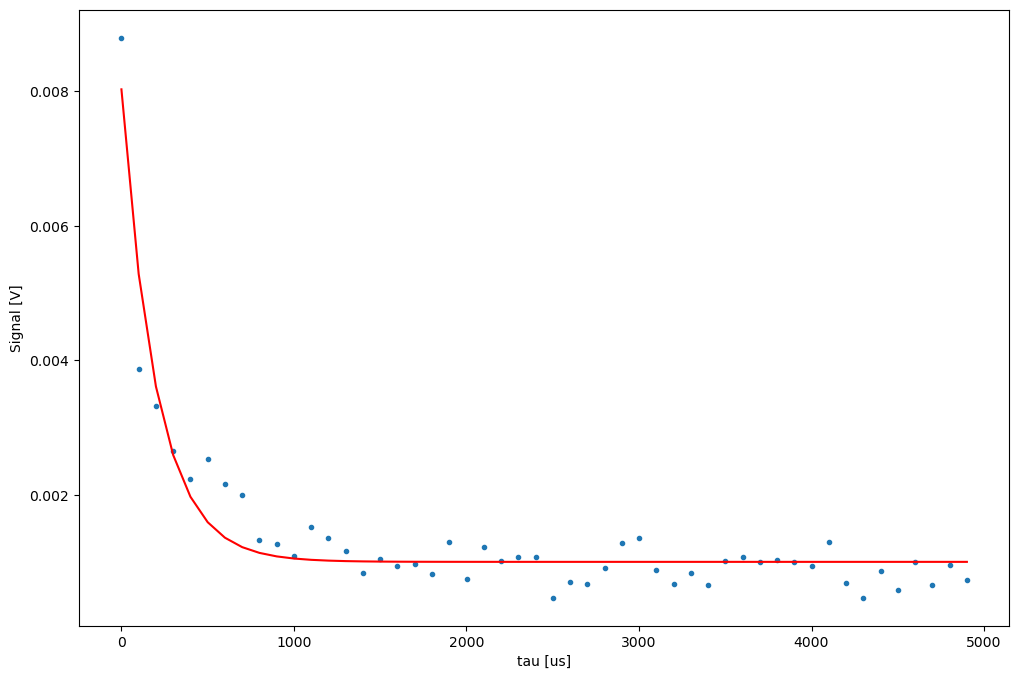

In [24]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")

# TLS drive

## TLS spectroscopy

### This cell is only for the first run, to estimate TLS freq

In [ ]:
# TLS freq estimate based on SWAP flux amplitude
TLS_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level)
TLS_freq_est = np.round(TLS_freq_est[0] * 1E6)
if len(machine.qubits[qubit_index].f_tls) < TLS_index + 2: # need to increase size
    machine.qubits[qubit_index].f_tls.append(int(TLS_freq_est.tolist()) + 0E6)
    machine.qubits[qubit_index].lo.append(int(TLS_freq_est.tolist()) - 200E6)
else: # just update the value
    machine.qubits[qubit_index].f_tls[TLS_index+1] = (int(TLS_freq_est.tolist()))
    machine.qubits[qubit_index].lo = int(TLS_freq_est.tolist()) - 200E6

### This is when we already have calibrated TLS freq saved somewhere

In [27]:
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index+1] + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 - 200E6
machine = Analysis.set_machine(machine)

In [28]:
# calibrate octave for TLS sweep
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine = machine,calibration_flag = True)

2024-02-05 10:18:58,993 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-05 10:18:58,999 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r2 for (LO, IF) = (7.054 GHz, -50.000 MHz)
2024-02-05 10:19:06,053 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q2 for (LO, IF) = (5.572 GHz, 200.000 MHz)
2024-02-05 10:19:19,269 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [36]:
%matplotlib qt
TLS_freq_sweep = machine.qubits[qubit_index].f_tls[TLS_index+1] + np.arange(-100E6,150E6+1,0.5E6)
machine, TLS_freq_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_freq(TLS_freq_sweep, qubit_index, res_index, flux_index, TLS_index,
                  n_avg = 1E3, cd_time_qubit = 20E3, cd_time_TLS = 2000E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 1011.92s


In [34]:
machine.qubits[qubit_index].f_tls[TLS_index+1]

5771658576.0

resonant frequency: 5902.684 MHz


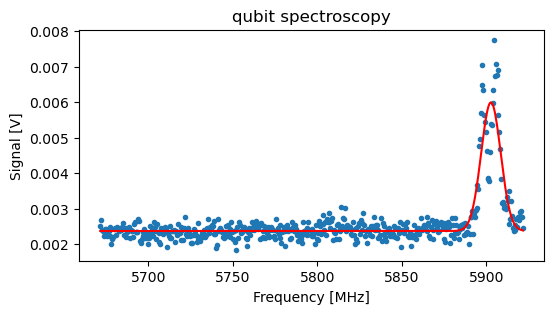

In [38]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=TLS_freq_sweep,y=sig_amp,method="gaussian")
# qubit_freq = int(qubit_freq.tolist())
# # update TLS freq
# machine.qubits[qubit_index].f_tls[TLS_index+1] = qubit_freq + 0E6
# # set the "qubit frequency"
# machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
# machine.qubits[qubit_index].lo = qubit_freq - 200E6
# # save the parameters
# machine = Analysis.set_machine(machine)

## TLS rabi

In [35]:
machine.flux_lines[flux_index].iswap.level[TLS_index] = 0.2
machine = Analysis.set_machine(machine)

In [8]:
machine.qubits[qubit_index].pi_amp_tls[TLS_index] = 0.45267857
machine = Analysis.set_machine(machine)

In [5]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 60 + 0.1, 5)  # in units of clock cyles
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,
                  n_avg = 2E3, cd_time_qubit = 20E3, cd_time_TLS = 100E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 2.84s
Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 2.93s


T2rabi: 3361.8 ns
rabi_pi_pulse: 84.6 ns
half period: 81.03 ns


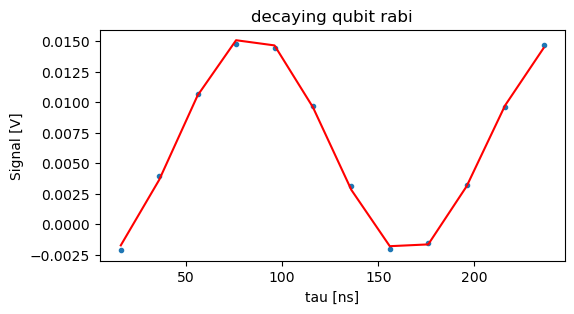

In [7]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,method = "decaying_time_rabi", plot_flag = True)

In [16]:
if len(machine.qubits[qubit_index].pi_length_tls) < TLS_index + 1: # need to increase size
    machine.qubits[qubit_index].pi_length_tls.append(84)
else: # just update the value
    machine.qubits[qubit_index].pi_length_tls[TLS_index] = 84
    
machine = Analysis.set_machine(machine)

## TLS Power Rabi

In [ ]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.3, 2.0, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, TLS_index = TLS_index,  
                                          n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 50E3, plot_flag = False, machine = machine)

In [ ]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [ ]:
if len(machine.qubits[qubit_index].pi_length_tls) < TLS_index + 1: # need to increase size
    machine.qubits[qubit_index].pi_amp_tls.append(pi_pulse_amp)
else: # just update the value
    machine.qubits[qubit_index].pi_amp_tls[TLS_index] = pi_pulse_amp
machine = Analysis.set_machine(machine)

## TLS Ramsey

In [18]:
%matplotlib qt
ramsey_duration_sweep = np.arange(4, 180 + 0.1, 2)  # in units of clock cyles
machine, ramsey_duration_sweep, sig_I = Experiment.exp1D.Ramsey.TLS_ramsey(ramsey_duration_sweep, qubit_index, res_index, flux_index, TLS_index,
          n_avg = 4E3, detuning = 10E6, cd_time_qubit = 20E3, cd_time_TLS = 100E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 43.44s
Execution stopped by user!


Qubit T2* [ns]: 315.1640855363132
Detuning [MHz]: 10.131615595602302
Exponent n: 1.6242764069793518


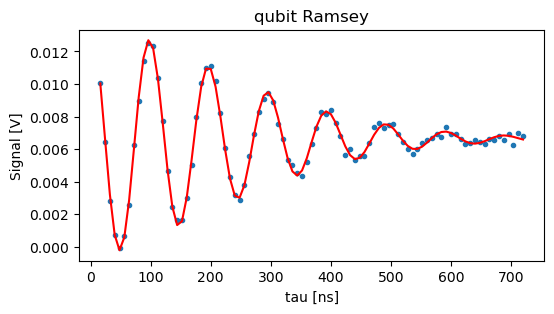

In [21]:
%matplotlib inline
q_T2star = Analysis.exp1D.ramsey(ramsey_duration_sweep, sig_I,plot_flag = True)

## TLS T1 with direct driving

In [5]:
%matplotlib qt
tau_sweep_abs = np.arange(200,800E3+1,10E3)
machine, tau_sweep_abs, sig_I = Experiment.exp1D.T1.TLS_T1_driving(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index,
                   n_avg = 2E3, cd_time_qubit = 20E3, cd_time_TLS = 400E3, simulate_flag = False, simulation_len = 15_000, plot_flag = True)

Execution stopped by user!                                   ] 7.0% (n=139/2000.0) --> elapsed time: 8.93s


Qubit T1 [us]: 156.0467442117647


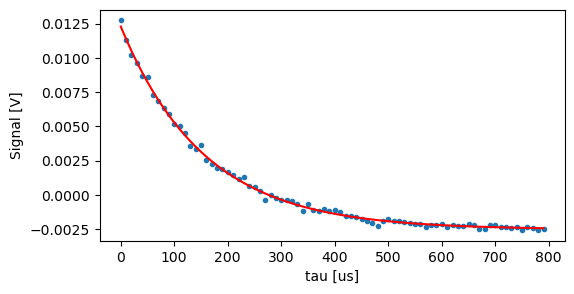

In [14]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_I,method = "exp")

# TLS Dynamical Decoupling

## TLS echo

In [3]:
%matplotlib qt
tau_sweep = np.arange(4, 2E3 + 0.1, 40)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_echo(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 400E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 85.82s
Execution stopped by user!


Qubit T1 [us]: 17.277648700542777


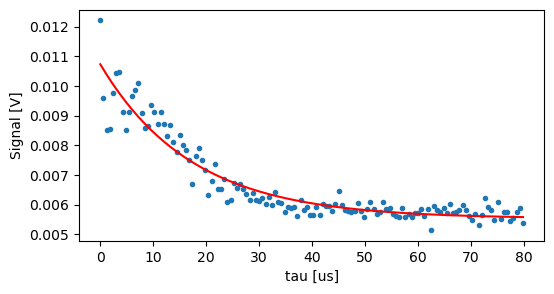

In [12]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(tau_sweep_abs*2,sig_I,method = "exp")

## TLS CPMG2

In [6]:
%matplotlib qt
tau_sweep = np.arange(4, 800 + 0.1, 4)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 2, n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 400E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 342.72s


## TLS CPMG4

In [ ]:
%matplotlib qt
tau_sweep = np.arange(4, 1600 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 4, n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 400E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

## TLS CPMG6

In [7]:
%matplotlib qt
tau_sweep = np.arange(4, 800 + 0.1, 2)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 6, n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 400E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 704.81s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 704.86s


## TLS CPMG8

In [8]:
%matplotlib qt
tau_sweep = np.arange(4, 800 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 8, n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 400E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 1428.85s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 1428.89s


## TLS CPMG12

In [9]:
%matplotlib qt
tau_sweep = np.arange(4, 800 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 12, n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 400E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 1470.99s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 1471.03s


## TLS CPMG16

In [10]:
%matplotlib qt
tau_sweep = np.arange(4, 800 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 16, n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 400E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 1512.98s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 1513.02s


## TLS CPMG20

In [11]:
%matplotlib qt
tau_sweep = np.arange(4, 800 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 20, n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 400E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 1555.12s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 1555.17s


## TLS CPMG24

In [12]:
%matplotlib qt
tau_sweep = np.arange(4, 800 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 24, n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 400E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 1597.11s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 1597.16s


## TLS CPMG28

In [13]:
%matplotlib qt
tau_sweep = np.arange(4, 800 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 28, n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 400E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 1639.26s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 1639.30s


## TLS CPMG32

In [14]:
%matplotlib qt
tau_sweep = np.arange(4, 800 + 0.1, 1)  # in units of clock cyles
machine, tau_sweep_abs, sig_I = Experiment.exp1D.DD.TLS_CPMG(tau_sweep, qubit_index, res_index, flux_index, TLS_index,
          N_CPMG = 32, n_avg = 4E3, cd_time_qubit = 20E3, cd_time_TLS = 400E3, plot_flag = False, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 1681.31s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 1681.38s
